In [1]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return

In [2]:
sns.set_style('whitegrid')
np.random.seed(42)
idx = pd.IndexSlice

results_path = Path('KR2_results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

DATA_STORE = Path(results_path / 'data.h5')
predictions = pd.read_hdf(results_path / 'predictions.h5', 'predictions')

In [3]:
factor = (predictions.mean(axis=1)
          .unstack('ticker')
          .resample('W-FRI', level='date')
          .last()
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())
tickers = factor.index.get_level_values('ticker').unique()
factor = factor.drop('2023-08-11', level=0)

new_multi_index = pd.MultiIndex.from_product([factor.index.get_level_values('date').unique(), tickers], names=['date', 'ticker'])
#factor.reset_index(level=0, drop=True, inplace=True)


In [4]:
df = pd.DataFrame(factor, index=new_multi_index)
df

0
date                      ticker             
2018-08-24 00:00:00+00:00 000020.KS  0.069303
                          000040.KS -0.012683
                          000050.KS  0.001028
                          000070.KS  0.083258
                          000075.KS -0.267058
...                                       ...
2023-08-04 00:00:00+00:00 456040.KS  0.033795
                          460850.KS  0.109553
                          460860.KS  0.088270
                          900140.KS -0.017655
                          950210.KS -0.038154

[222222 rows x 1 columns]

In [5]:
def get_trade_prices(tickers):
    prices = pd.read_hdf(DATA_STORE, 'stocks/prices/adjusted')
    prices.index.names = ['ticker', 'date']
    prices = prices.loc[idx[tickers, '2018-08-24':'2023-08-04'], 'open']
    return (prices
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .resample('W-FRI', level='date')
            .last()
            .tz_localize('UTC'))

trade_prices = get_trade_prices(tickers)

In [12]:
from alphalens.utils import get_clean_factor_and_forward_returns
factor_data = get_clean_factor_and_forward_returns(factor=df,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=[5]).sort_index()
factor_data.info()

delta_days error
Dropped 6.0% entries from factor data: 6.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 208807 entries, (Timestamp('2018-08-24 00:00:00+0000', tz='UTC', freq='C'), '000020.KS') to (Timestamp('2023-06-30 00:00:00+0000', tz='UTC', freq='C'), '950210.KS')
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   5D               208807 non-null  float64
 1   factor           208807 non-null  float32
 2   factor_quantile  208807 non-null  int64  
dtypes: float32(1), float64(1), int64(1)
memory usage: 4.8+ MB


In [13]:
factor_data

5D    factor  factor_quantile
date                      asset                                         
2018-08-24 00:00:00+00:00 000020.KS -0.013158  0.069303                3
                          000040.KS  0.003490 -0.012683                2
                          000050.KS -0.044281  0.001028                2
                          000070.KS -0.004902  0.083258                4
                          000075.KS  0.033645 -0.267058                1
...                                       ...       ...              ...
2023-06-30 00:00:00+00:00 456040.KS  0.034426 -0.004478                2
                          460850.KS -0.137806  0.000560                3
                          460860.KS  0.211101  0.002648                3
                          900140.KS  0.122363  0.010165                3
                          950210.KS  0.265543 -0.016189                1

[208807 rows x 3 columns]

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.370411,-0.015245,-0.154064,0.114041,41848,20.041474
2,-0.292263,0.018936,-0.046754,0.033521,41721,19.980652
3,-0.215319,0.087438,0.005527,0.031193,41724,19.982089
4,-0.138319,0.184219,0.054608,0.042211,41721,19.980652
5,-0.041914,0.539136,0.127563,0.074537,41793,20.015134


Returns Analysis


,5D
Ann. alpha,-0.058
beta,0.065
Mean Period Wise Return Top Quantile (bps),-32.144
Mean Period Wise Return Bottom Quantile (bps),-9.872
Mean Period Wise Spread (bps),-22.272


Information Analysis


,5D
IC Mean,-0.027
IC Std.,0.115
Risk-Adjusted IC,-0.236
t-stat(IC),-3.763
p-value(IC),0.000
IC Skew,-0.174
IC Kurtosis,-0.304


Turnover Analysis


,5D
Quantile 1 Mean Turnover,0.473
Quantile 2 Mean Turnover,0.698
Quantile 3 Mean Turnover,0.728
Quantile 4 Mean Turnover,0.713
Quantile 5 Mean Turnover,0.526


,5D
Mean Factor Rank Autocorrelation,0.552


<Figure size 640x480 with 0 Axes>

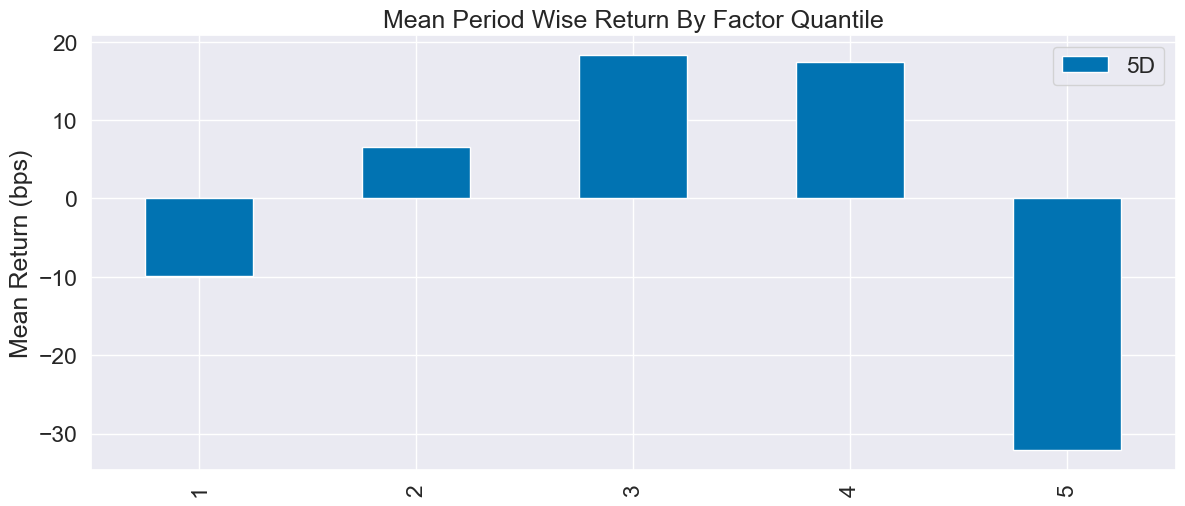

In [14]:
create_summary_tear_sheet(factor_data)

In [17]:
factor_data.to_pickle("temp_factor_data.pkl")

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.370411,-0.015245,-0.154064,0.114041,41848,20.041474
2,-0.292263,0.018936,-0.046754,0.033521,41721,19.980652
3,-0.215319,0.087438,0.005527,0.031193,41724,19.982089
4,-0.138319,0.184219,0.054608,0.042211,41721,19.980652
5,-0.041914,0.539136,0.127563,0.074537,41793,20.015134


Returns Analysis


,5D
Ann. alpha,-0.058
beta,0.065
Mean Period Wise Return Top Quantile (bps),-32.144
Mean Period Wise Return Bottom Quantile (bps),-9.872
Mean Period Wise Spread (bps),-22.272


<Figure size 640x480 with 0 Axes>

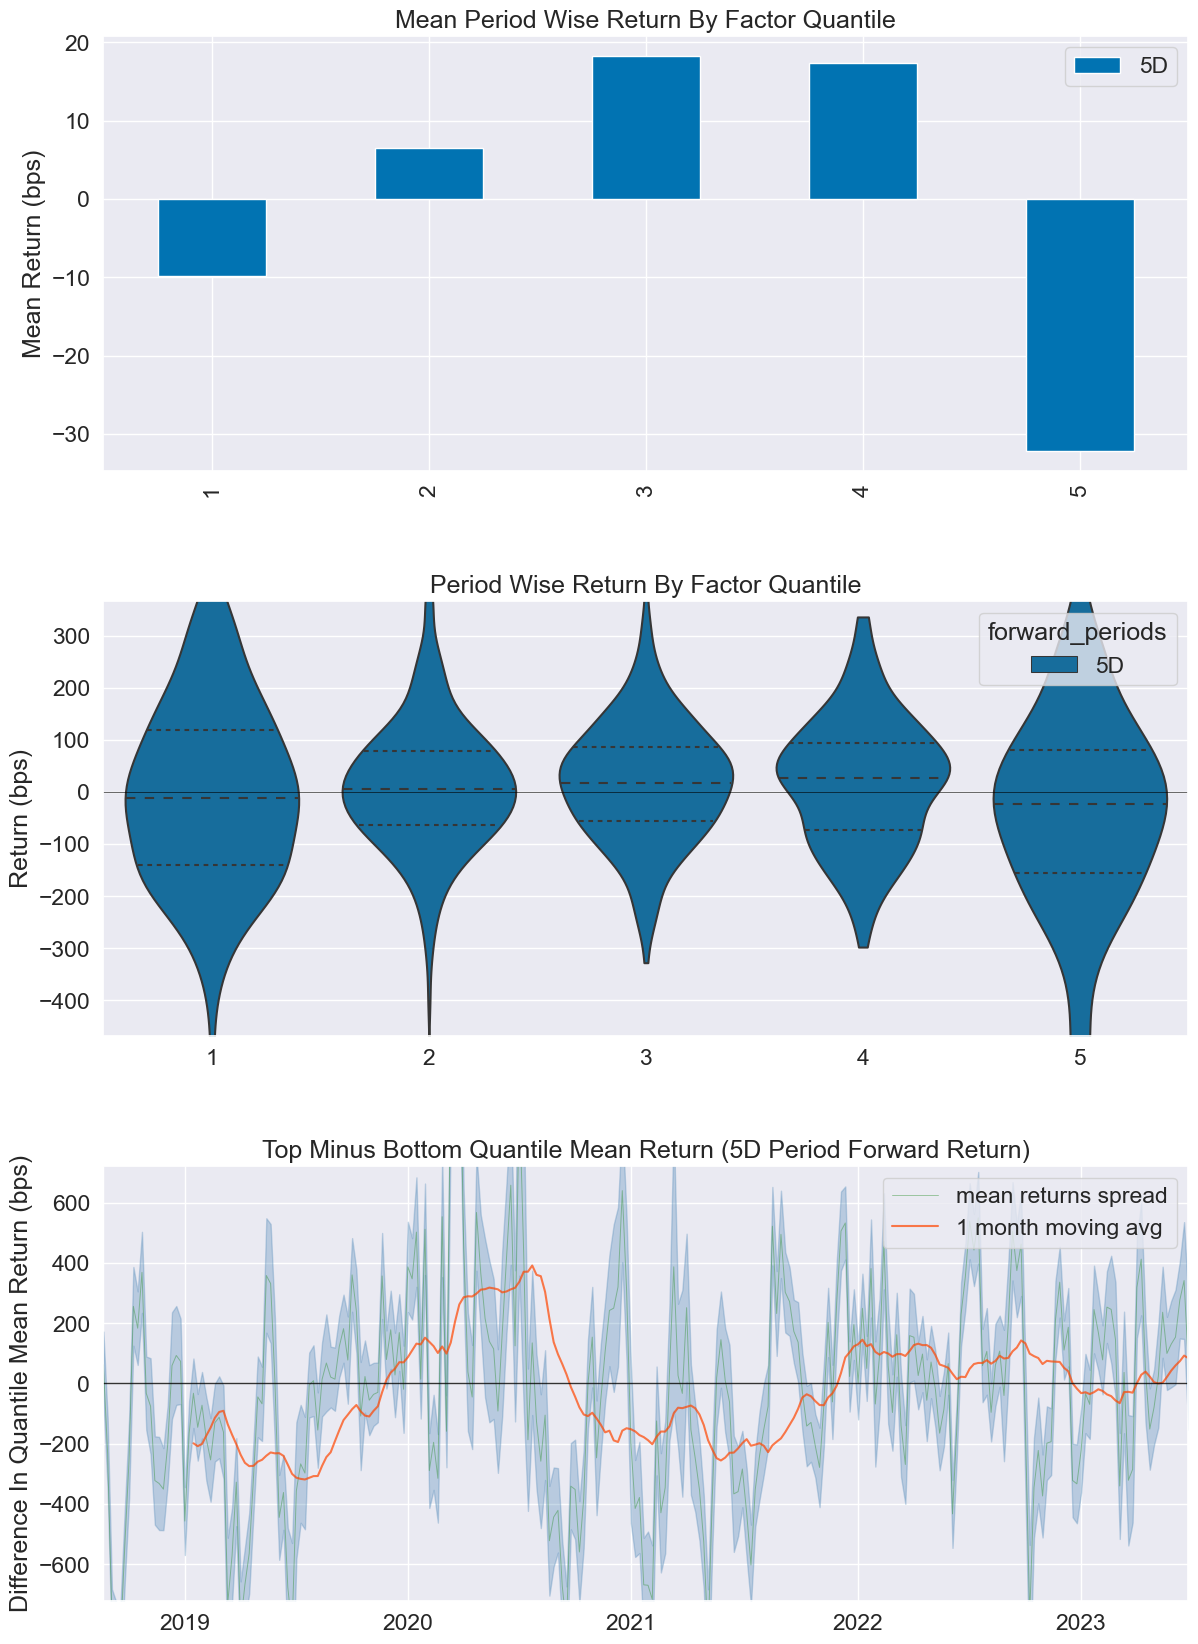

Information Analysis


,5D
IC Mean,-0.027
IC Std.,0.115
Risk-Adjusted IC,-0.236
t-stat(IC),-3.763
p-value(IC),0.000
IC Skew,-0.174
IC Kurtosis,-0.304


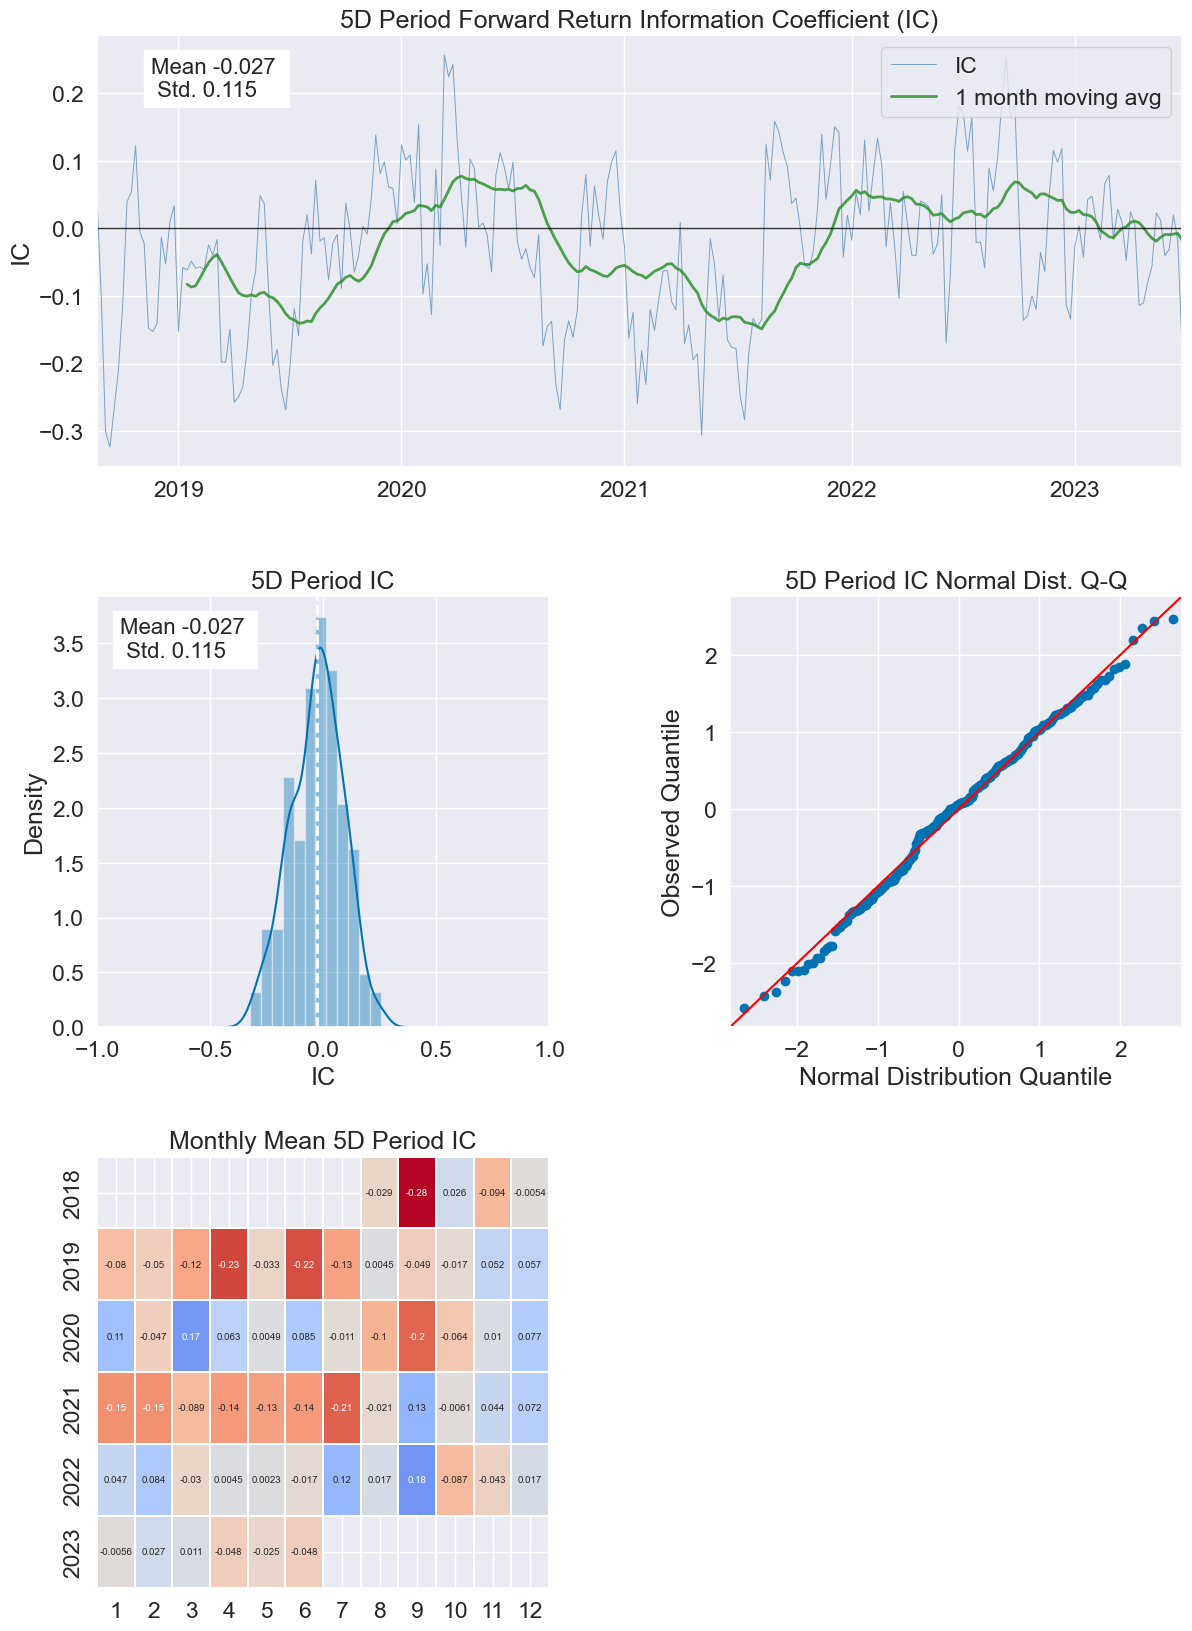

AttributeError: 'Index' object has no attribute 'get_values'

In [15]:
create_full_tear_sheet(factor_data)